# Visualizations

## Mel-spectrograms Visualization

In [1]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
# PARAMETERS
SR = 12000 # sample rate: 12KHz
len_src = 29. # duration: 29 secs
ref_n_src = 12000 * 29

In [8]:
PATH_FIGURE = '/Users/pengguo/Desktop/coms4995/Project/figures/'

# Load sound file
# y, sr = librosa.load("/Users/pengguo/Desktop/coms4995/Project/datasets/gtzan_genre/genres/jazz/jazz.00005.au")
path_jazz = "/Users/pengguo/Desktop/coms4995/Project/datasets/gtzan_genre/genres/jazz/jazz.00033.au" # train idx 485
path_classical = "/Users/pengguo/Desktop/coms4995/Project/datasets/gtzan_genre/genres/classical/classical.00079.au" # train idx 175

def show_spectrogram(path):
    src, sr = librosa.load(path, sr=SR, duration=len_src * SR / float(SR))
    
    # Unify the length of src (in case its longer than ref_n_src)
    src = src[:ref_n_src]
    result = np.zeros(ref_n_src)
    result[:len(src)] = src[:ref_n_src]
    
    # transform src to mel-spectrogram
    src_ms = librosa.feature.melspectrogram(y=result, n_fft=512, hop_length=256, power=2.0, sr=SR, n_mels=96, \
                                   fmin=0.0, fmax=6000)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.logamplitude(src_ms, ref_power=np.max)

    # Make a new figure
    fig = plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=SR, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    
    # Display image
    plt.show()
    
    # Save image
    if path.split('/')[-2] == "jazz":
        fig.savefig(PATH_FIGURE + 'jazz_full.png')
    elif path.split('/')[-2] == "classical":
        fig.savefig(PATH_FIGURE + 'classical_full.png')
    
    return

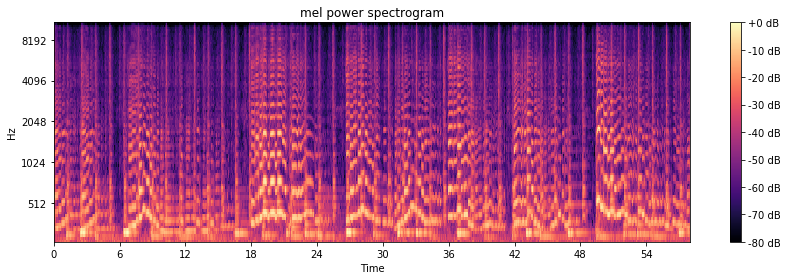

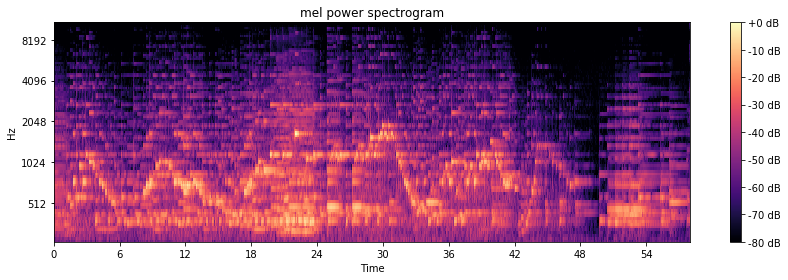

In [9]:
show_spectrogram(path_jazz)
show_spectrogram(path_classical)

## CNN Intermediate Layer Visualization

In [25]:
import numpy as np
import keras
from keras.layers import Input, Dense, merge, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model
from kapre.time_frequency import Melspectrogram
from keras.utils.visualize_util import plot

Using Theano backend.


### Find Designated melgram

In [12]:
# PATH TO ORIGIN DATASET, MODIFY THIS TO THE PATH OF DATASET ON YOUR COMPUTER!
PATH_DATASET = '/Users/pengguo/Desktop/coms4995/Project/datasets/gtzan_genre/genres/'
# PATH TO ROOT DIRECTORY
PATH_ROOT = './'

# PATH TO CSV FILE
TRAIN_CSV = PATH_ROOT + 'gtzan_train.csv'
TEST_CSV = PATH_ROOT + 'gtzan_test.csv'

# PATH TO ACTUAL DATA
X_TRAIN = PATH_ROOT + 'dataset/X_train.npy'
Y_TRAIN = PATH_ROOT + 'dataset/Y_train.npy'
X_TEST = PATH_ROOT + 'dataset/X_test.npy'
Y_TEST = PATH_ROOT + 'dataset/Y_test.npy'

# PARAMETERS
SR = 12000 # sample rate: 12KHz
len_src = 29. # duration: 29 secs
ref_n_src = 12000 * 29

In [15]:
### Helper Functions ###
def gen_filepaths(df):
    '''
    A Generator reading file paths from dataframe.
    Inputs:
        - df: Dataframe converted from .csv file.
    Return:
        - paths to each audio file
    '''
    for filepath in df['filepath']:
        yield os.path.join(PATH_DATASET, filepath)


def _load_audio(path):
    '''
    Load audio file at path with sampling rate=SR, duration=len_src, and return it
    '''
    src, sr = librosa.load(path, sr=SR, duration=len_src * SR / float(SR))
    
    # Unify the length of src (in case its longer than ref_n_src)
    src = src[:ref_n_src]
    result = np.zeros(ref_n_src)
    result[:len(src)] = src[:ref_n_src]
    
    # transform src to mel-spectrogram
    src_ms = librosa.feature.melspectrogram(y=result, n_fft=512, hop_length=256, power=2.0, sr=SR, n_mels=96, \
                                   fmin=0.0, fmax=6000)
    
    return src_ms


def gen_X(PATH_CSV, PATH_SAVE, NUM_DATA):
    '''
    Convert GTZAN audio files to a single .npy file.
    shape of X: (1000, 1, 348000)
    '''
    print 'Start generating X...'
    df = pd.DataFrame.from_csv(PATH_CSV) # load csv
    filepaths = gen_filepaths(df)  # filepaths: generator
    
    raw_data = np.array([_load_audio(filepaths.next()) for _ in xrange(NUM_DATA)])
    data = raw_data[:, np.newaxis, :, :] # "Insert" one dimension
    np.save(PATH_SAVE, data)
    return data

In [20]:
X_train = gen_X(TRAIN_CSV, X_TRAIN, 900)

Start generating X...


In [29]:
np.save('/Users/pengguo/Desktop/coms4995/Project/figures/X_train_rawspec.npy', X_train)

In [22]:
# Select spectrogram(s) to draw (jazz -- 485, classical -- 175)
X_jazz = X_train[485:486, :, :, :]
X_classical = X_train[175:176, :, :, :]

In [23]:
X_jazz.shape

(1, 1, 96, 1360)

### Define Model

In [85]:
# input
x = Input(shape=(1, 96, 1360))
# melgram = Melspectrogram(n_dft=512, n_hop=256, power_melgram=2.0,
#                                 # input_shape=(1, input_length),
#                                      trainable_kernel=False,
#                                      trainable_fb=False,
#                                      return_decibel_melgram=True,
#                                      sr=12000, n_mels=96,
#                                      fmin=0.0, fmax=6000,
#                                      name='melgram')(x)

# 1st conv layer
conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', trainable=False)(x)
conv1 = BatchNormalization(axis=1, mode=2, trainable=False)(conv1)
conv1 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv1)
conv1 = MaxPooling2D(pool_size=(2, 4))(conv1)
avg1 = GlobalAveragePooling2D()(conv1)

# 2nd conv layer
conv2 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', trainable=False)(conv1)
conv2 = BatchNormalization(axis=1, mode=2, trainable=False)(conv2)
conv2 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv2)
conv2 = MaxPooling2D(pool_size=(3, 4))(conv2)
avg2 = GlobalAveragePooling2D()(conv2)

# 3rd conv layer
conv3 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', trainable=False)(conv2)
conv3 = BatchNormalization(axis=1, mode=2, trainable=False)(conv3)
conv3 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv3)
conv3 = MaxPooling2D(pool_size=(2, 5))(conv3)
avg3 = GlobalAveragePooling2D()(conv3)

# 4th conv layer
conv4 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', trainable=False)(conv3)
conv4 = BatchNormalization(axis=1, mode=2, trainable=False)(conv4)
conv4 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv4)
conv4 = MaxPooling2D(pool_size=(2, 4))(conv4)
avg4 = GlobalAveragePooling2D()(conv4)

# 5th conv layer
conv5 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', trainable=False)(conv4)
conv5 = BatchNormalization(axis=1, mode=2, trainable=False)(conv5)
conv5 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv5)
conv5 = MaxPooling2D(pool_size=(4, 4))(conv5)
avg5 = GlobalAveragePooling2D()(conv5)

# Concatenate 5 intermediate outputs
concatenated = merge([avg1, avg2, avg3, avg4, avg5], mode='concat', concat_axis=1)

# Fully-connected & dropout layers
dense1 = Dense(32, input_shape=[160], activation='relu')(concatenated)
dr1 = Dropout(0.2)(dense1)
out = Dense(10, input_shape=[32], activation='softmax')(dr1)

In [86]:
# Build Model
model = Model(input=x, output=out)

In [87]:
# load pre-trained weights
PATH_WEIGHTS = '/Users/pengguo/Desktop/coms4995/Project/GTZAN_music_genre_tagger/weights/weights_layer4_theano.hdf5'
model.load_weights(PATH_WEIGHTS, by_name=True)

In [101]:
# Plotting
from keras import backend as K
%matplotlib inline

def plot_featmaps(X_toplot, name):
    # Activition layers: 3, 7, 11, 15, 19
    act_layers = [3, 7, 11, 15, 19]

    path = '/Users/pengguo/Desktop/coms4995/Project/figures/feat_maps/{}/'.format(name)
    if not os.path.exists(path):
        os.mkdir(path)

    for j, act in enumerate(act_layers):
        # Create Keras backend function
        convout1_f = K.function([model.layers[0].input], [model.layers[act].output])
        convolutions = convout1_f([X_toplot])
        
        sub_path = path + 'conv_{}/'.format(j)
        if not os.path.exists(sub_path):
            os.mkdir(sub_path)
        
        # Plot all intermediate output for one conv layer
        for i, convolution in enumerate(convolutions[0][0]):
            fig = plt.figure()
            plt.title("Conv Layer {} #{}".format(j+1, i))
            plt.imshow(convolution, cmap='gray')
            fig.savefig(sub_path + '{}.png'.format(i))

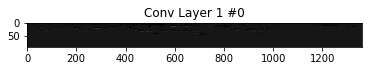

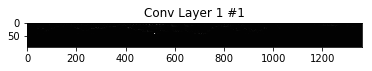

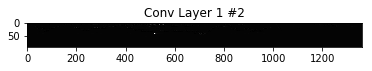

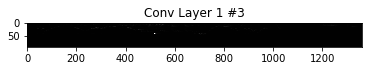

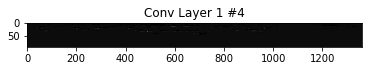

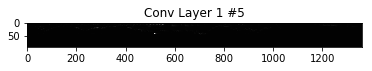

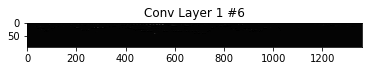

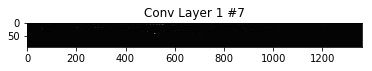

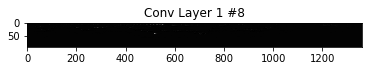

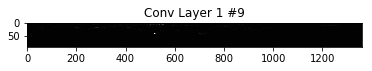

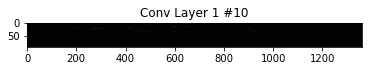

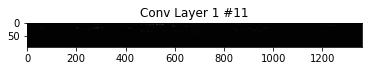

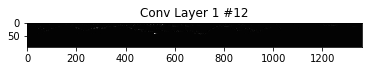

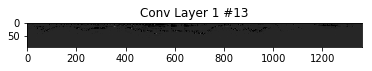

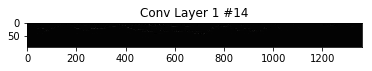

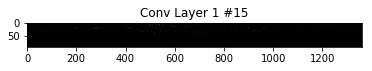

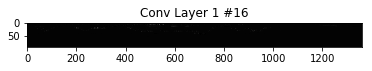

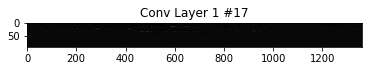

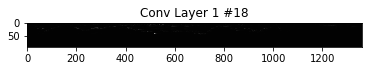

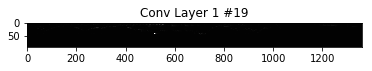

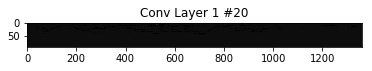

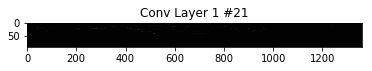

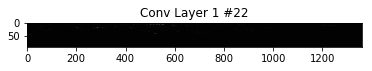

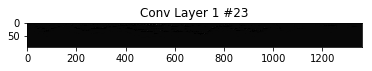

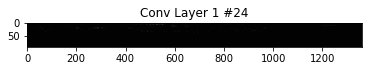

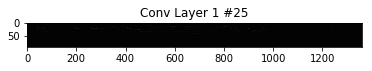

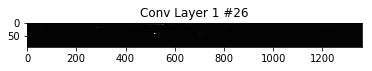

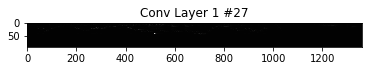

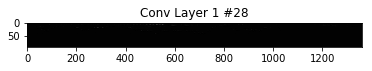

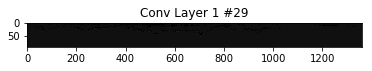

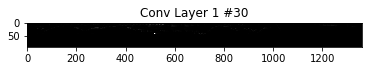

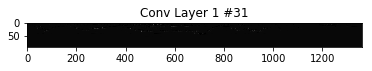

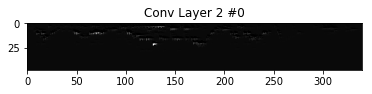

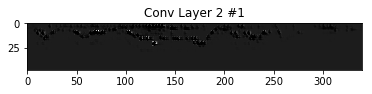

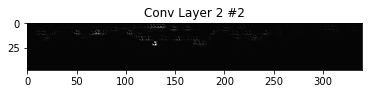

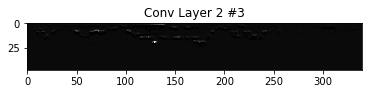

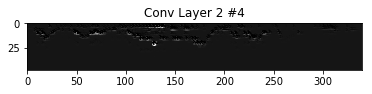

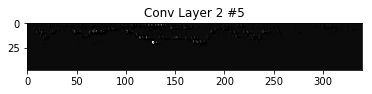

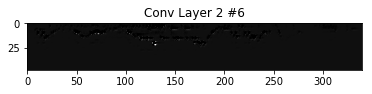

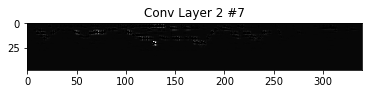

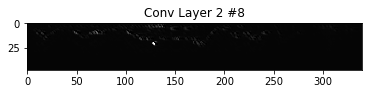

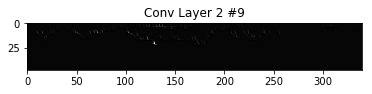

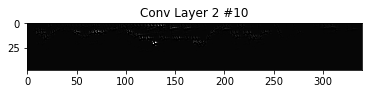

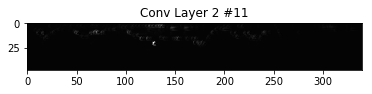

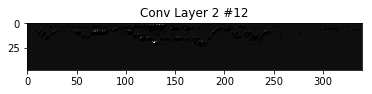

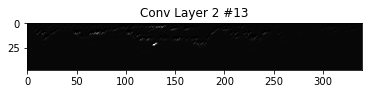

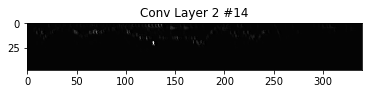

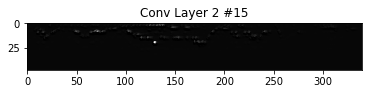

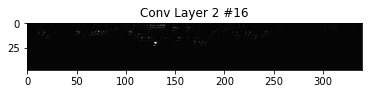

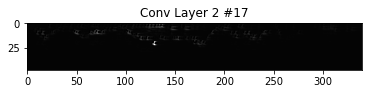

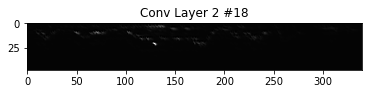

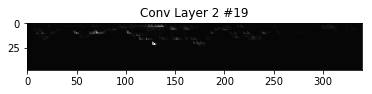

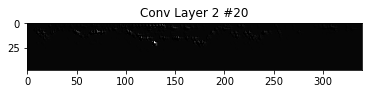

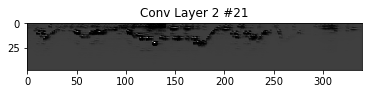

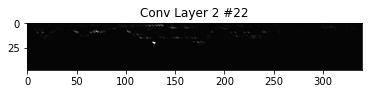

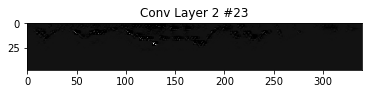

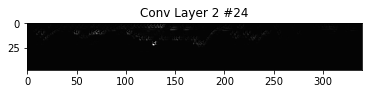

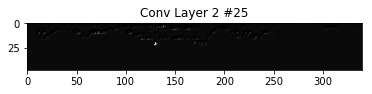

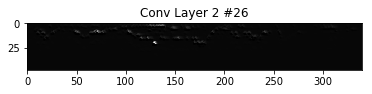

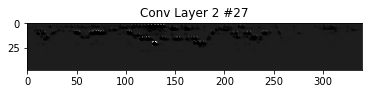

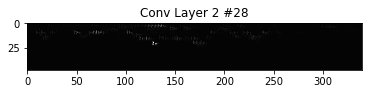

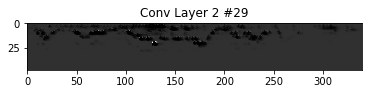

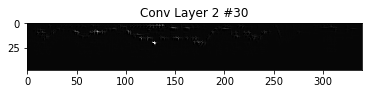

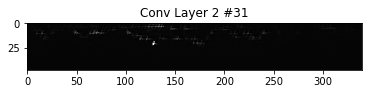

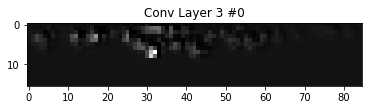

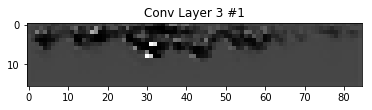

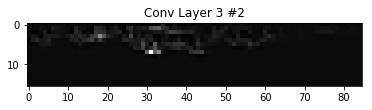

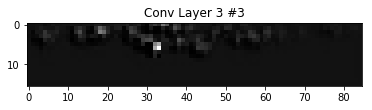

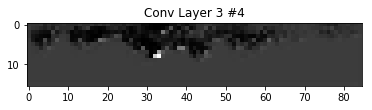

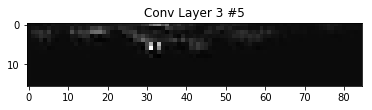

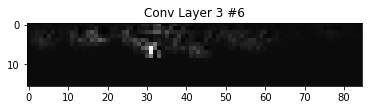

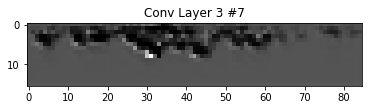

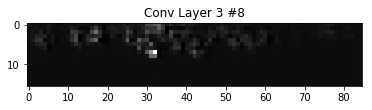

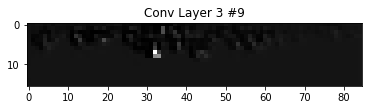

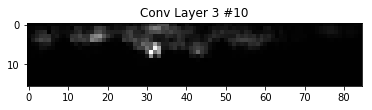

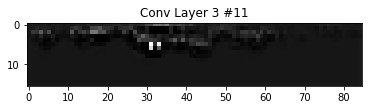

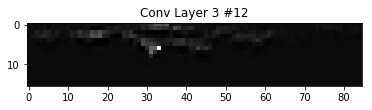

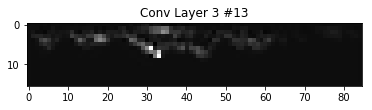

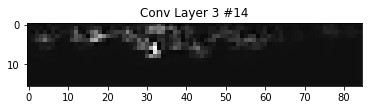

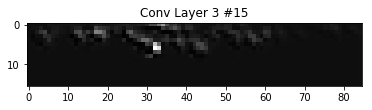

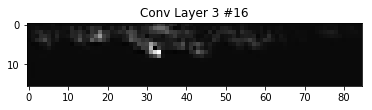

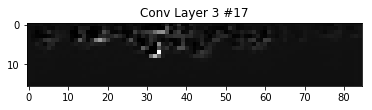

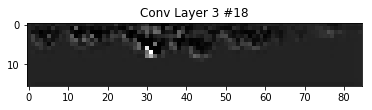

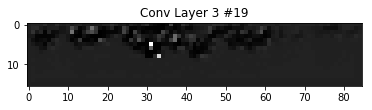

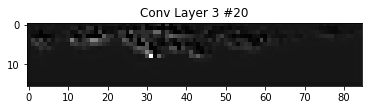

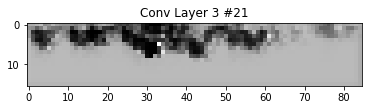

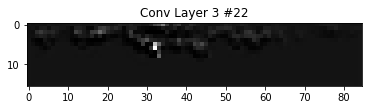

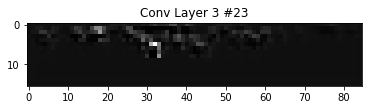

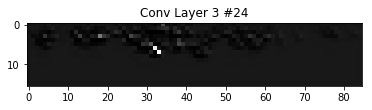

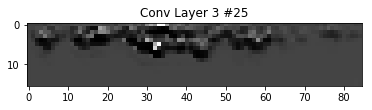

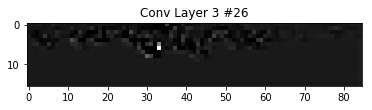

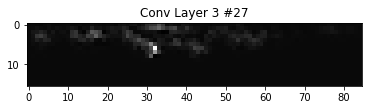

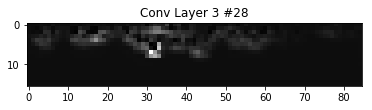

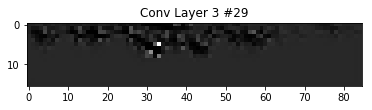

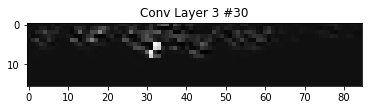

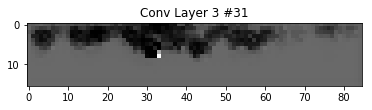

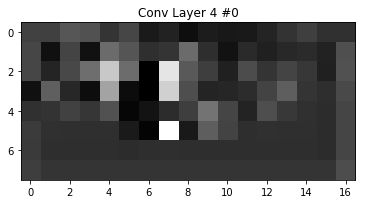

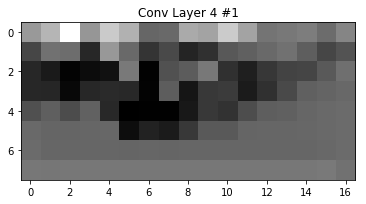

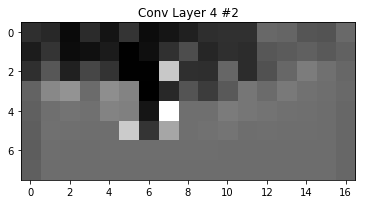

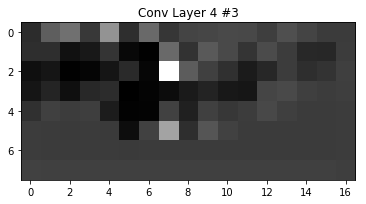

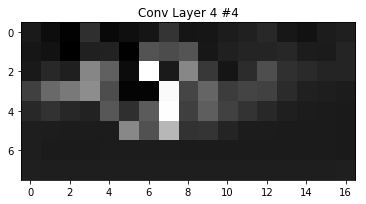

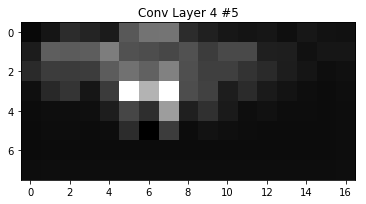

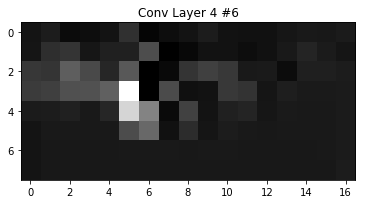

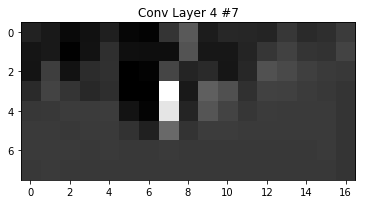

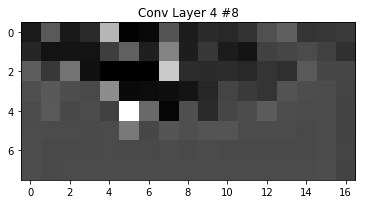

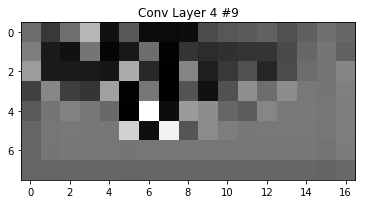

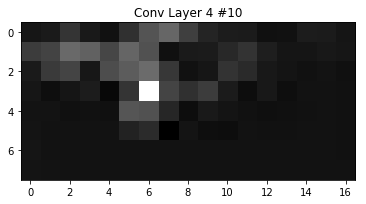

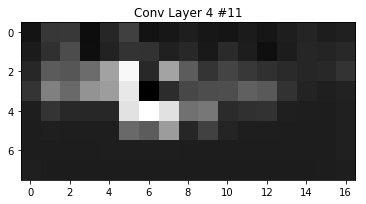

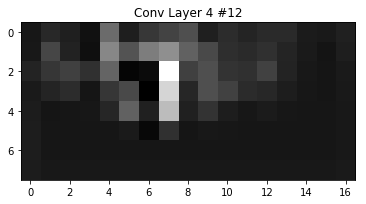

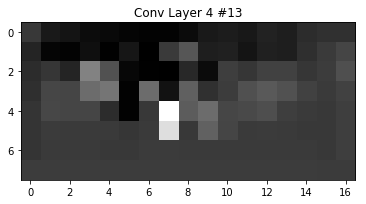

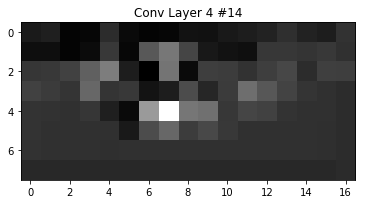

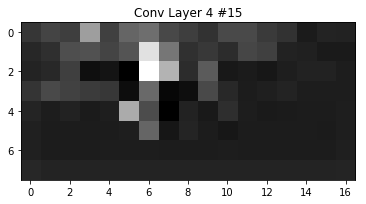

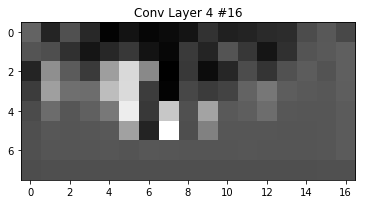

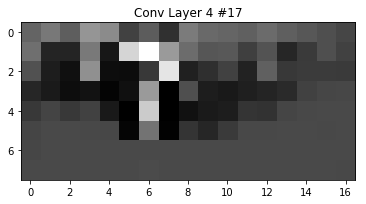

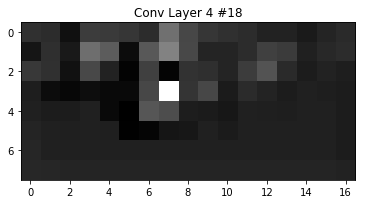

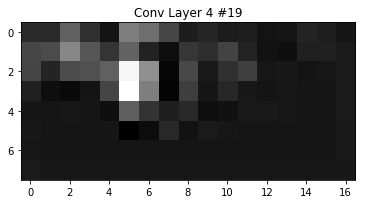

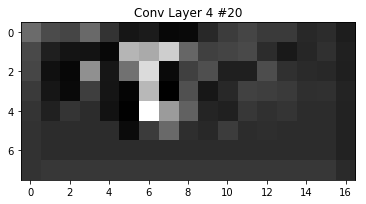

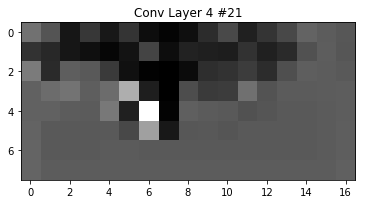

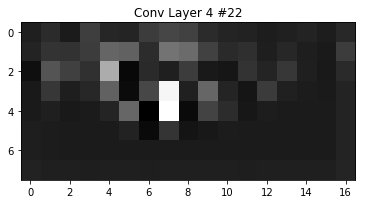

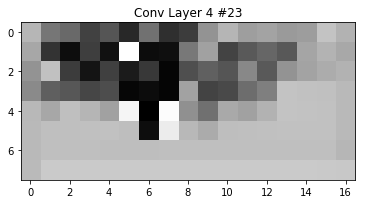

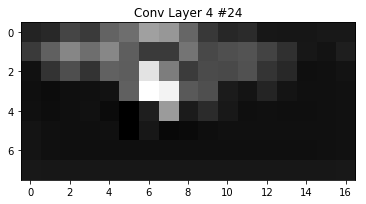

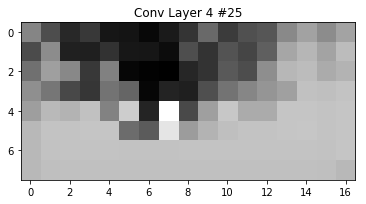

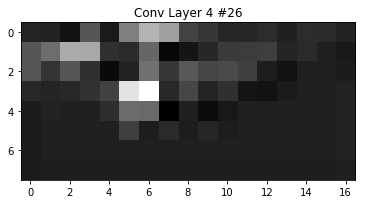

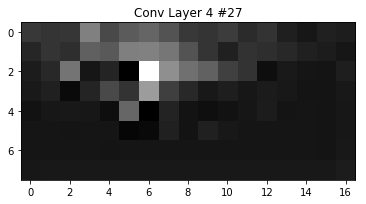

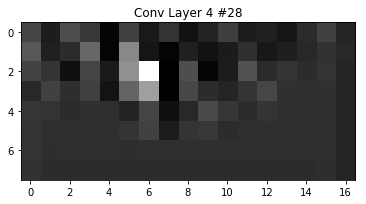

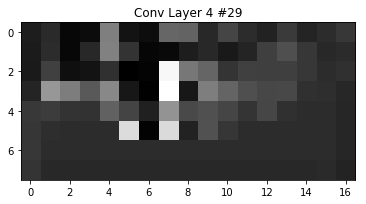

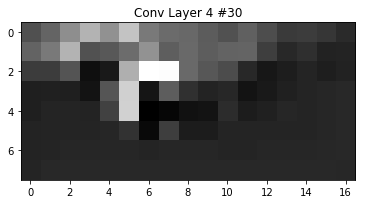

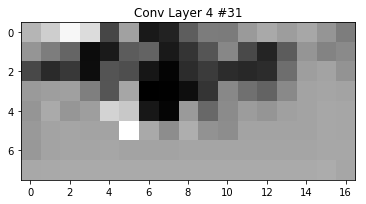

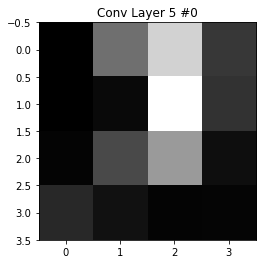

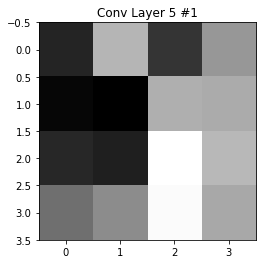

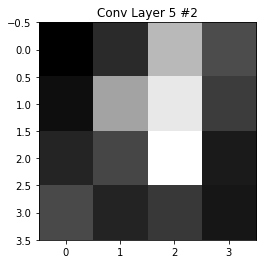

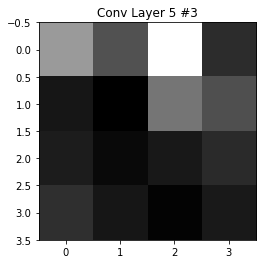

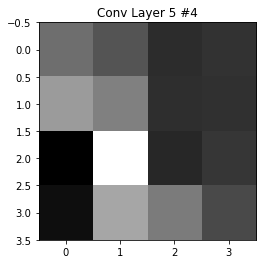

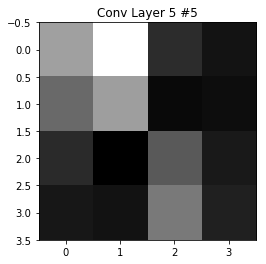

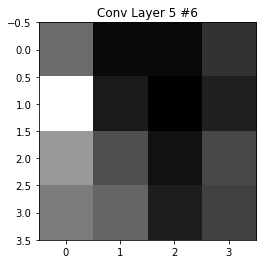

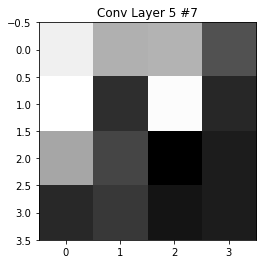

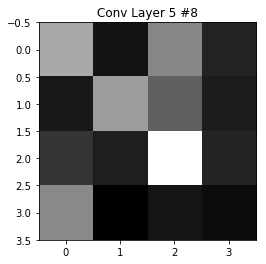

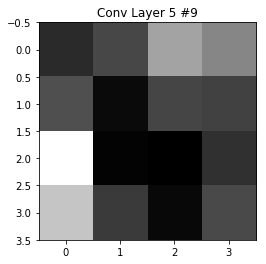

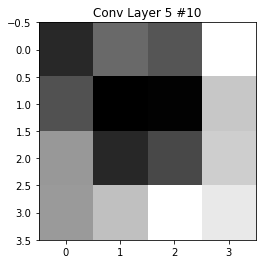

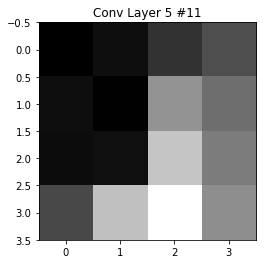

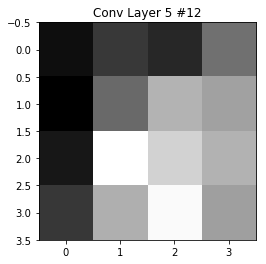

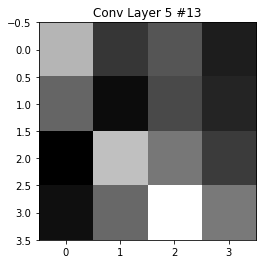

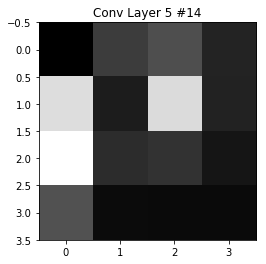

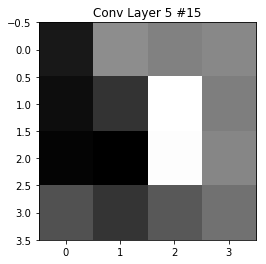

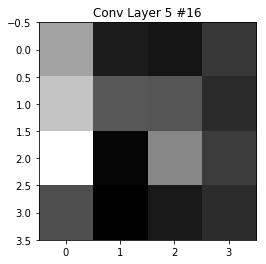

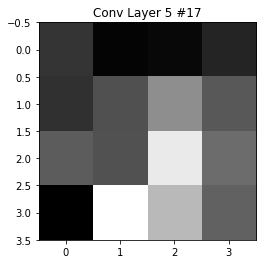

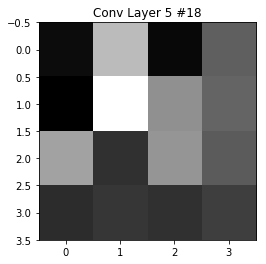

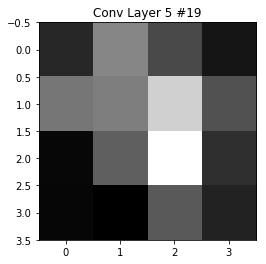

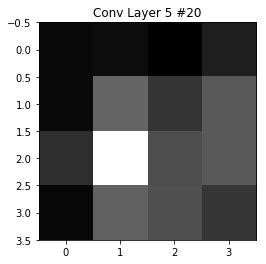

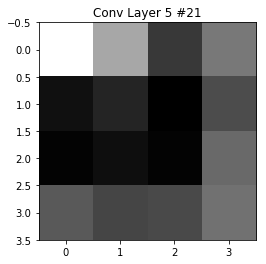

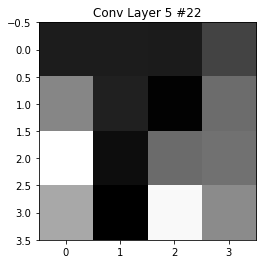

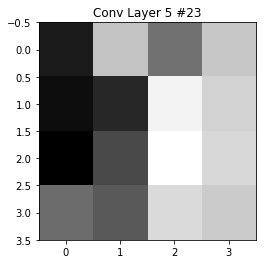

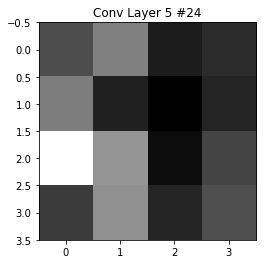

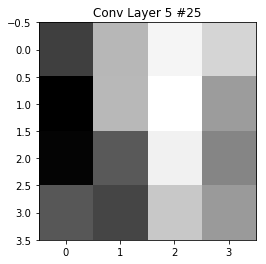

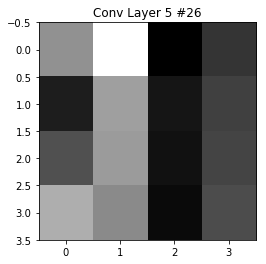

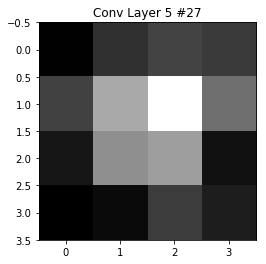

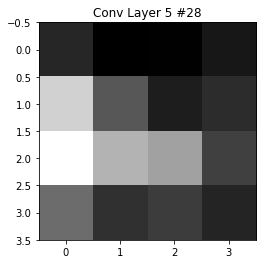

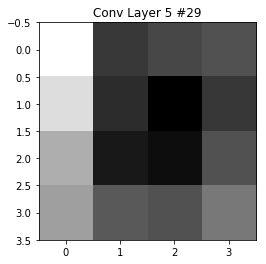

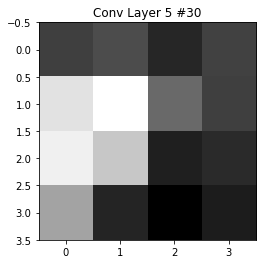

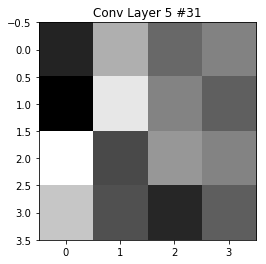

In [103]:
plot_featmaps(X_classical, 'classical_1')

In [77]:
# K.function([model.layers[0].input],
#                                   [model.layers[3].output])
convolutions[0][0].shape

(32, 48, 340)

In [47]:
[model.layers[5].output]

[Elemwise{add,no_inplace}.0]

In [104]:
model.layers

In [5]:
### Plot function ###
def plot_acc_loss(model_his_list, seg_length):
    '''
    Plot train/val acc & loss in model training.
    '''
    path = '/Users/pengguo/Desktop/coms4995/Project/figures/local_cnns/'
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot([num for model_his in model_his_list for num in model_his['acc']])
    plt.plot([num for model_his in model_his_list for num in model_his['val_acc']])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(path + 'acc_{}.png'.format(seg_length))

    # summarize history for loss
    fig = plt.figure()
    plt.plot([num for model_his in model_his_list for num in model_his['loss']])
    plt.plot([num for model_his in model_his_list for num in model_his['val_loss']])
#     plt.plot(model_his.history['loss'])
#     plt.plot(model_his.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(path + 'loss_{}.png'.format(seg_length))
    
    return

In [3]:
# Load training histories
import pickle
path = '/Users/pengguo/Desktop/coms4995/Project/Multi_scale/train_logs/'
name_20 = ['train_his_20_2017-12-10-16-16-51']
name_30 = ['train_his_30_2017-12-10-16-16-20']
name_60 = ['train_his_60_2017-12-10-16-15-27']
name_120 = ['train_his_120_2017-12-10-05-36-02']
name_240 = ['train_his_240_2017-12-10-06-44-19']


def wrapper(names, seg_length):
    path = '/Users/pengguo/Desktop/coms4995/Project/Multi_scale/train_logs/'
    history = []
    for name in names:
        with open(path + name) as f:
            history.append(pickle.load(f))
    plot_acc_loss(history, seg_length)

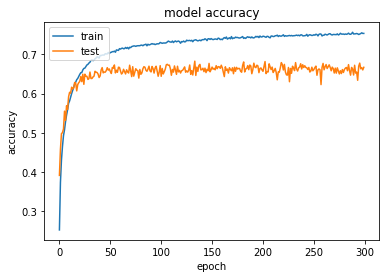

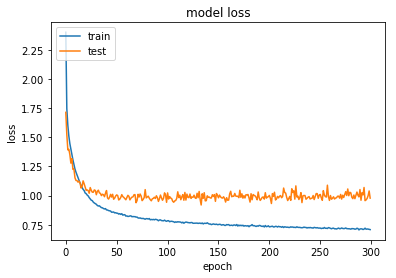

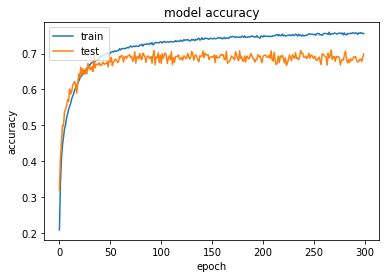

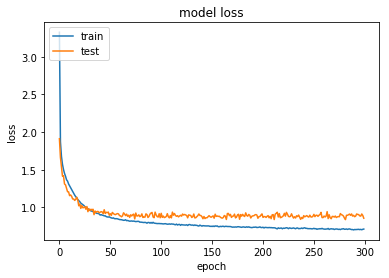

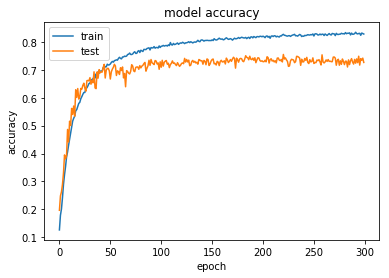

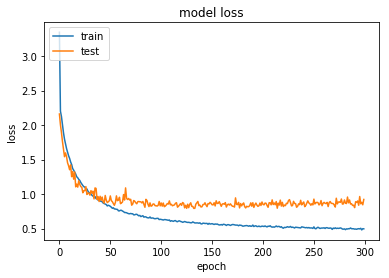

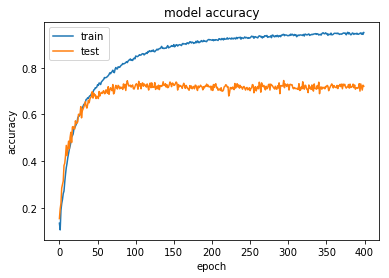

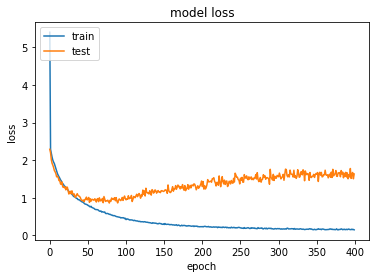

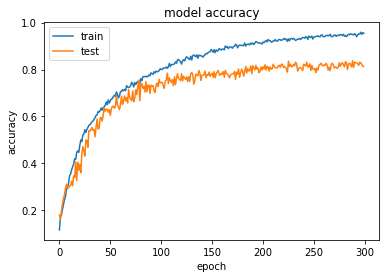

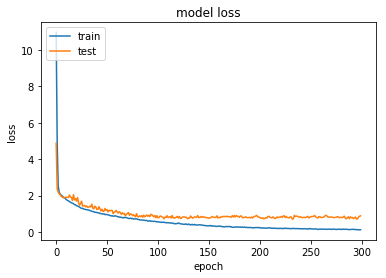

In [119]:
wrapper(name_20, 20)
wrapper(name_30, 30)
wrapper(name_60, 60)
wrapper(name_120, 120)
wrapper(name_240, 240)

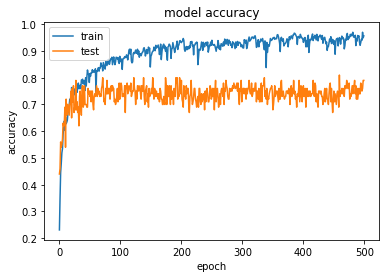

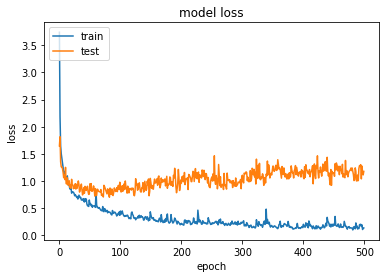

In [7]:
name_fc = ['train_his_FC_2017-12-13-23-42-08']
wrapper(name_fc, 'fc')